In [2]:
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import pandas as pd
import numpy as np
# !conda install -c conda-forge geopy --yes # uncomment this line if this is not installed yet
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if this is not installed yet
import folium # map rendering library
import seaborn as sns


#### Read PM25 and Hospital data

In [4]:
df=pd.read_csv('df1-North-Holland-3-by-3-km.csv',index_col=0)
hospitals=pd.read_csv('df_hospitals_Netherlands_unfiltered.csv',index_col=0)
df.dropna(subset=['location'],inplace=True) # only use data if address is available
df = df[df['location'].str.match("Nederland",case=True)==False]  # If it contains Nederland only it is actually the sea

Run k-means to cluster pm25 into 10 cluster.

In [5]:
# set number of clusters
kclusters = 5

test = df[['pm25']]
pm25 = df.copy()
test.head()

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(test)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

from https://stackoverflow.com/questions/44888415/how-to-set-k-means-clustering-labels-from-highest-to-lowest-with-python
This shows how I can use colors from high to low

In [6]:
kmeans.cluster_centers_.sum(axis=1)

array([10.45081633,  9.70456604, 13.10333333,  8.78154386, 11.44309091])

Create Lookup table

In [7]:
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(kclusters)

In [8]:
#idx

In [9]:
#lut

idx shows the cluster center labels ordered from lowest to highest consumption level. 

Colorscale created using http://colorbrewer2.org/#type=sequential&scheme=Blues&n=5

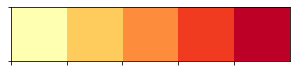

In [12]:
color_scale = np.array(['#ffffb2','#fecc5c','#fd8d3c','#f03b20','#bd0026'])
sns.palplot(sns.color_palette(color_scale))

In [13]:
#pm25.insert(0, 'Cluster Labels', kmeans.labels_)
pm25.insert(0,'Cluster Labels',lut[kmeans.labels_])  # insert sorted labels

In [14]:
pm25.head()

,Cluster Labels,pm25,lat,long,rd_x,rd_y,location
2,0,9.107,52.979766,4.657665,106000.0,555000.0,"Den Hoorn, Texel, Noord-Holland, Nederland"
3,0,8.971,52.980030,4.702328,109000.0,555000.0,"Den Hoorn, Texel, Noord-Holland, Nederland"
4,0,8.907,52.980278,4.746992,112000.0,555000.0,"Den Hoorn, Texel, Noord-Holland, Nederland"
5,0,8.561,52.980509,4.791655,115000.0,555000.0,"Den Hoorn, Texel, Noord-Holland, Nederland"
6,0,8.373,52.980723,4.836320,118000.0,555000.0,"Den Helder, Noord-Holland, Nederland"


In [15]:
#pm25.to_csv(r'df-kmeanstest2.csv')

I think I can best add 
upper_left
upper_right
lower_right
lower_left

to PM25 based on starting point in RijksCoordinate.
If Rijkscoordinate is x,y then I need to add like this(+ convert to lat,long)  
lower_left = x-1500,y-1500  
upper_right = x+1500,y+1500 

In [16]:
from RDWGSConverter import RDWGSConverter  # import module to convert Rijksdriehoek coordinates into latitude and longitude
conv = RDWGSConverter()

In [17]:
dftemp = pm25.copy()
#dftemp = dftemp.astype({"rd_x": int, "rd_y": int})
def my_func(x,y):
    lower_left_x,lower_left_y=conv.fromRdToWgs([x-1500,y-1500])    
    upper_right_x,upper_right_y=conv.fromRdToWgs([x+1500,y+1500])  
 
    return [lower_left_x,lower_left_y,upper_right_x,upper_right_y]

dftemp["lower_left_x"],dftemp["lower_left_y"], \
    dftemp["upper_right_x"],dftemp["upper_right_y"], \
    = my_func(dftemp['rd_x'],dftemp['rd_y'])
dftemp.head()



,Cluster Labels,pm25,lat,long,rd_x,rd_y,location,lower_left_x,lower_left_y,upper_right_x,upper_right_y
2,0,9.107,52.979766,4.657665,106000.0,555000.0,"Den Hoorn, Texel, Noord-Holland, Nederland",52.966150,4.635567,52.993379,4.679778
3,0,8.971,52.980030,4.702328,109000.0,555000.0,"Den Hoorn, Texel, Noord-Holland, Nederland",52.966422,4.680215,52.993635,4.724455
4,0,8.907,52.980278,4.746992,112000.0,555000.0,"Den Hoorn, Texel, Noord-Holland, Nederland",52.966678,4.724865,52.993874,4.769132
5,0,8.561,52.980509,4.791655,115000.0,555000.0,"Den Hoorn, Texel, Noord-Holland, Nederland",52.966917,4.769515,52.994097,4.813810
6,0,8.373,52.980723,4.836320,118000.0,555000.0,"Den Helder, Noord-Holland, Nederland",52.967139,4.814165,52.994302,4.858489


Finally, let's visualize the resulting clusters

In [18]:
# create map
latitude = 52.962226  #  Zeepromenade, Huisduinen, Den Helder
longitude = 4.732374  #  Zeepromenade, Huisduinen, Den Helder 
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Show hospitals in the Netherlands
# Use Circle since I want to show a radius in meters
# CircleMarker has radius in pixels    
markers_colors = []
for lat, lon, poi in zip(hospitals['location.lat'], hospitals['location.lng'], hospitals['name'],):
    #label = folium.Popup(str(poi) , parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=8000,
    #    popup=label,
    #    color=rainbow[cluster-1],
        fill=True,
    #    fill_color=rainbow[cluster-1],
        fill_opacity=0.0).add_to(map_clusters)
# add markers to the map
markers_colors = []
for lat1, lon1,lat2,lon2, poi,cluster in zip(dftemp['lower_left_x'], dftemp['lower_left_y'],dftemp['upper_right_x'], dftemp['upper_right_y'], dftemp['pm25'],dftemp['Cluster Labels'],):

    label = folium.Popup(str(poi) , parse_html=True)
    folium.Rectangle(
        bounds=[[lat1,lon1],[lat2,lon2]],
        popup=label,    
    #    color=rainbow[cluster-1],
        color=color_scale[cluster],
        fill=True,
        fill_color=color_scale[cluster],
       fill_opacity=0.4).add_to(map_clusters)
    

markers_colors = []
for lat, lon, poi in zip(hospitals['location.lat'], hospitals['location.lng'], hospitals['name'],):
    label = folium.Popup(str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
    #    color=rainbow[cluster-1],
        fill=True,
    #    fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)    
    
map_clusters